> __Purpose:__ Implement an initial privacy attack to quantify how much re-identiifcation and linkability risk exists from personalization parameters (the decoder used in the co-adaptation algorithm). Thus, implement a basic ML model to link the decoder matrices back to the corresponding subject.  

- This NB is based off of NB107.  
- May want to log, save, and write all the decs from NBs 201/202.  
- Not sure whether it is worth testing on all conditions (e.g. to generate more training data for this adversarial model). I did so since there were so few instances of each class in the training data otherwise.  Well really each update doesn't matter only the user so maybe I didn't need to do that   
- Also should save the adversarial models from earlier NBs (102, 104, 106, 107) and see how they perform on this data
- Plot adversarial accuracy wrt each local iteration.  Currently am plotting wrt to each update, which amy be better, if condensing things much more heavily

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
from kcs_ml_infr import *
from experiment_params import *
from fl_sim_classes import *

import seaborn as sns
from presentation_sns_config import *

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

#import warnings
#warnings.filterwarnings("ignore")

random.seed(a=1)

In [2]:
final_update = 16

## Load Data

In [3]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

# For exclusion when plotting later on
bad_nodes = [1,3,13]

In [4]:
with open('Data\continuous_full_data_block1.pickle', 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, Ws_block1, _, _, _, _, _ = pickle.load(handle)

cond1b1_dict_list = [0]*num_participants
cond2b1_dict_list = [0]*num_participants
cond3b1_dict_list = [0]*num_participants
cond4b1_dict_list = [0]*num_participants
cond5b1_dict_list = [0]*num_participants
cond6b1_dict_list = [0]*num_participants
cond7b1_dict_list = [0]*num_participants
cond8b1_dict_list = [0]*num_participants
for idx in range(num_participants):
    b1_emg = emgs_block1[keys[idx]]
    b1_ref = refs_block1[keys[idx]]
    cond1b1_dict_list[idx] = {'training':b1_emg[0,:,:], 'labels':b1_ref[0,:,:]}
    cond2b1_dict_list[idx] = {'training':b1_emg[1,:,:], 'labels':b1_ref[1,:,:]}
    cond3b1_dict_list[idx] = {'training':b1_emg[2,:,:], 'labels':b1_ref[2,:,:]}
    cond4b1_dict_list[idx] = {'training':b1_emg[3,:,:], 'labels':b1_ref[3,:,:]}
    cond5b1_dict_list[idx] = {'training':b1_emg[4,:,:], 'labels':b1_ref[4,:,:]}
    cond6b1_dict_list[idx] = {'training':b1_emg[5,:,:], 'labels':b1_ref[5,:,:]}
    cond7b1_dict_list[idx] = {'training':b1_emg[6,:,:], 'labels':b1_ref[6,:,:]}
    cond8b1_dict_list[idx] = {'training':b1_emg[7,:,:], 'labels':b1_ref[7,:,:]}
    
    cond1b1_AllInitDecs_list = [Ws_block1[keys[i]][0, 0, :, :] for i in range(num_participants)]
    cond2b1_AllInitDecs_list = [Ws_block1[keys[i]][1, 0, :, :] for i in range(num_participants)]
    cond3b1_AllInitDecs_list = [Ws_block1[keys[i]][2, 0, :, :] for i in range(num_participants)]
    cond4b1_AllInitDecs_list = [Ws_block1[keys[i]][3, 0, :, :] for i in range(num_participants)]
    cond5b1_AllInitDecs_list = [Ws_block1[keys[i]][4, 0, :, :] for i in range(num_participants)]
    cond6b1_AllInitDecs_list = [Ws_block1[keys[i]][5, 0, :, :] for i in range(num_participants)]
    cond7b1_AllInitDecs_list = [Ws_block1[keys[i]][6, 0, :, :] for i in range(num_participants)]
    cond8b1_AllInitDecs_list = [Ws_block1[keys[i]][7, 0, :, :] for i in range(num_participants)]


## No-FL Case

In [5]:
users_c1 = [Client(i, cond1b1_AllInitDecs_list[i], 'FullScipyMinStep', cond1b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_c1 = Server(-1, D_0, 'NoFL', users_c1, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_c1.execute_FL_loop()

In [6]:
users_c2 = [Client(i, cond2b1_AllInitDecs_list[i], 'FullScipyMinStep', cond2b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=2, delay_scaling=0) for i in range(14)]
global_c2 = Server(-1, D_0, 'NoFL', users_c2, PCA_comps=64)

users_c3 = [Client(i, cond3b1_AllInitDecs_list[i], 'FullScipyMinStep', cond3b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=3, delay_scaling=0) for i in range(14)]
global_c3 = Server(-1, D_0, 'NoFL', users_c3, PCA_comps=64)

users_c4 = [Client(i, cond4b1_AllInitDecs_list[i], 'FullScipyMinStep', cond4b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=4, delay_scaling=0) for i in range(14)]
global_c4 = Server(-1, D_0, 'NoFL', users_c4, PCA_comps=64)

users_c5 = [Client(i, cond5b1_AllInitDecs_list[i], 'FullScipyMinStep', cond5b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=5, delay_scaling=0) for i in range(14)]
global_c5 = Server(-1, D_0, 'NoFL', users_c5, PCA_comps=64)

users_c6 = [Client(i, cond6b1_AllInitDecs_list[i], 'FullScipyMinStep', cond6b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=6, delay_scaling=0) for i in range(14)]
global_c6 = Server(-1, D_0, 'NoFL', users_c6, PCA_comps=64)

users_c7 = [Client(i, cond7b1_AllInitDecs_list[i], 'FullScipyMinStep', cond7b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=7, delay_scaling=0) for i in range(14)]
global_c7 = Server(-1, D_0, 'NoFL', users_c7, PCA_comps=64)

users_c8 = [Client(i, cond8b1_AllInitDecs_list[i], 'FullScipyMinStep', cond8b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=8, delay_scaling=0) for i in range(14)]
global_c8 = Server(-1, D_0, 'NoFL', users_c8, PCA_comps=64)

num_updates_left = 19
for i in range(num_updates_left):
    global_c2.execute_FL_loop()
    global_c3.execute_FL_loop()
    global_c4.execute_FL_loop()
    global_c5.execute_FL_loop()
    global_c6.execute_FL_loop()
    global_c7.execute_FL_loop()
    global_c8.execute_FL_loop()

In [7]:
t0 = time.time()

dec_flattened1 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened2 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened3 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened4 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened5 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened6 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened7 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened8 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
for key_idx, key in enumerate(keys):
    for update_number, update_idx in enumerate(update_ix):
        dec_flattened1.loc[len(dec_flattened1)] = [key, update_number, np.ravel(users_c1[key_idx].dec_log[update_number])]
        dec_flattened2.loc[len(dec_flattened2)] = [key, update_number, np.ravel(users_c2[key_idx].dec_log[update_number])]
        dec_flattened3.loc[len(dec_flattened3)] = [key, update_number, np.ravel(users_c3[key_idx].dec_log[update_number])]
        dec_flattened4.loc[len(dec_flattened4)] = [key, update_number, np.ravel(users_c4[key_idx].dec_log[update_number])]
        dec_flattened5.loc[len(dec_flattened5)] = [key, update_number, np.ravel(users_c5[key_idx].dec_log[update_number])]
        dec_flattened6.loc[len(dec_flattened6)] = [key, update_number, np.ravel(users_c6[key_idx].dec_log[update_number])]
        dec_flattened7.loc[len(dec_flattened7)] = [key, update_number, np.ravel(users_c7[key_idx].dec_log[update_number])]
        dec_flattened8.loc[len(dec_flattened8)] = [key, update_number, np.ravel(users_c8[key_idx].dec_log[update_number])]        
        
t1 = time.time()
total = t1-t0  
print(total)

3.4763100147247314


In [8]:
# Concat all the dfs into a single training input dataframe
dec_flattened = pd.concat([dec_flattened1, dec_flattened2, dec_flattened3, dec_flattened4, dec_flattened5, dec_flattened6, dec_flattened7, dec_flattened8], ignore_index=True, axis=0)

# Make each ele its own cell
expanded_dec_df = dec_flattened.join(dec_flattened['Flattened Dec'].apply(pd.Series)).drop('Flattened Dec', axis=1)
print(expanded_dec_df.shape)
expanded_dec_df.head()

(2128, 130)


,Subject,Update Number,0,1,2,3,4,5,6,7,...,118,119,120,121,122,123,124,125,126,127
0,METACPHS_S106,0,0.002722,0.002606,0.003087,0.009610,0.009477,0.004051,0.000124,0.001421,...,0.005588,0.005065,0.004476,0.004007,0.006816,0.005033,0.008904,0.005124,0.006046,0.005625
1,METACPHS_S106,1,0.001243,0.002463,0.000509,0.006686,0.003009,0.000508,0.001013,-0.000711,...,0.003395,0.005837,0.005295,0.000999,0.001312,0.005053,0.008816,0.007758,0.006377,0.000240
2,METACPHS_S106,2,-0.000372,0.003810,-0.000075,0.005709,0.000862,-0.000247,-0.004618,-0.004766,...,0.001921,0.004090,0.003355,0.000977,0.002347,0.004636,0.005648,0.002985,0.001597,-0.003138
3,METACPHS_S106,3,0.001009,0.002855,-0.000121,0.005214,-0.002227,-0.003420,0.000007,-0.011986,...,-0.000223,0.003248,0.003910,0.002329,0.003220,0.004468,0.007297,0.001446,0.004493,-0.006419
4,METACPHS_S106,4,-0.000174,0.001306,-0.001158,0.004879,-0.001811,-0.005817,-0.001812,-0.010339,...,0.002242,0.000138,0.000030,0.001989,0.002812,0.004116,0.007054,0.003373,0.004395,-0.007981


In [9]:
assert(np.sum(expanded_dec_df.isnull().values)==0)

# Adversarial Modeling

In [10]:
#my_models = [LogisticRegression(), KNeighborsClassifier(), GradientBoostingClassifier()]
my_models = [LogisticRegression(), KNeighborsClassifier(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()]

In [11]:
def make_all_update_models(flattened_input_df, n_start_stop=(0, 18), num_kfolds=5, stratification=False, my_metrics_columns=['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds'], my_models_list=[LogisticRegression(), KNeighborsClassifier(), GaussianNB(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()], make_df=True, full_test_df=pd.DataFrame()):

    if make_df:
        full_test_df = pd.DataFrame(columns=my_metrics_columns)

    if n_start_stop[1]>=17:
        n_stop=16
    else:
        n_stop = n_start_stop[1]
    for i in range(n_start_stop[0], n_stop+1):
        #print(f"Round i={i} of stop={n_start_stop[1]}")
        ith_df, ith_test_df = nth_decoder_model(flattened_input_df, i, my_models_list, stratification=stratification, cv=num_kfolds, test=True)

        full_test_df = pd.concat((full_test_df, ith_test_df))

    full_test_df.drop('K Folds', axis=1, inplace=True)
    full_test_df.drop('One Off Acc', axis=1, inplace=True)
    full_test_df.drop('CV Acc', axis=1, inplace=True)

    return full_test_df

In [12]:
full_test_df = make_all_update_models(expanded_dec_df, stratification=True)
print(full_test_df.shape)
full_test_df.head(8)

(119, 3)


,Algorithm,Test Acc,N
0,LogisticRegression(),17.647,0
0,KNeighborsClassifier(),50.0,0
0,GaussianNB(),91.176,0
0,LinearSVC(),17.647,0
0,SGDClassifier(),41.176,0
0,DecisionTreeClassifier(),100.0,0
0,GradientBoostingClassifier(),100.0,0
0,LogisticRegression(),11.765,1


## Plot Accuracy As a Func of N

In [13]:
lr_df = full_test_df[full_test_df['Algorithm']=='LogisticRegression()']
knn_df = full_test_df[full_test_df['Algorithm']=='KNeighborsClassifier()']
svc_df = full_test_df[full_test_df['Algorithm']=='LinearSVC()']
sgd_df = full_test_df[full_test_df['Algorithm']=='SGDClassifier()']
dt_df = full_test_df[full_test_df['Algorithm']=='DecisionTreeClassifier()']
gbt_df = full_test_df[full_test_df['Algorithm']=='GradientBoostingClassifier()']

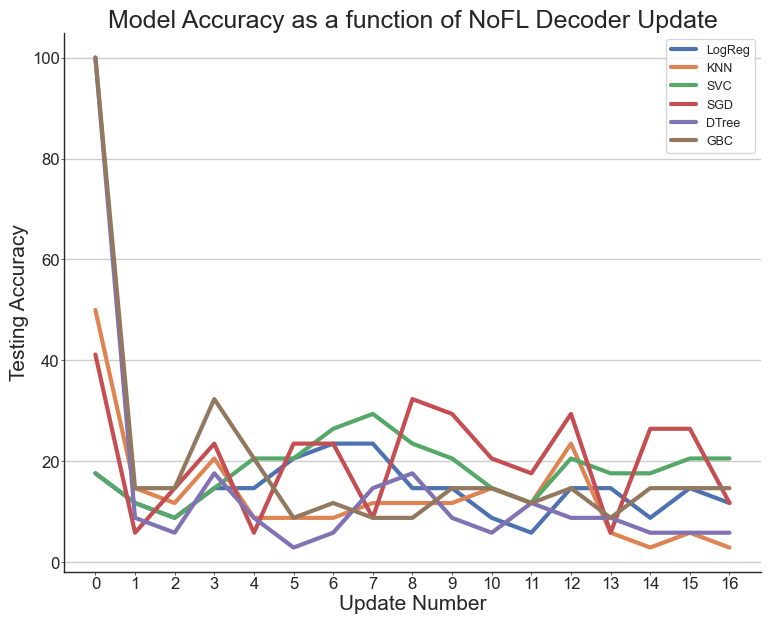

In [14]:
col_num = 1
my_x_updates = list(range(17))

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, lr_df.iloc[:, col_num], label='LogReg')
plt.plot(my_x_updates, knn_df.iloc[:, col_num], label='KNN')
plt.plot(my_x_updates, svc_df.iloc[:, col_num], label='SVC')
plt.plot(my_x_updates, sgd_df.iloc[:, col_num], label='SGD')
plt.plot(my_x_updates, dt_df.iloc[:, col_num], label='DTree')
plt.plot(my_x_updates, gbt_df.iloc[:, col_num], label='GBC')
plt.xticks(np.arange(0, final_update+1, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

In [15]:
nofl_mean_df = pd.DataFrame()
nofl_mean_df = pd.concat([nofl_mean_df, lr_df['Test Acc']], axis=1)
nofl_mean_df = pd.concat([nofl_mean_df, knn_df['Test Acc']], axis=1)
nofl_mean_df = pd.concat([nofl_mean_df, svc_df['Test Acc']], axis=1)
nofl_mean_df = pd.concat([nofl_mean_df, sgd_df['Test Acc']], axis=1)
nofl_mean_df = pd.concat([nofl_mean_df, gbt_df['Test Acc']], axis=1)
nofl_mean_series_no_dt = nofl_mean_df.mean(axis=1)
print(nofl_mean_series_no_dt.shape)
print(nofl_mean_series_no_dt)
print()

# Drop DT?
nofl_mean_df = pd.concat([nofl_mean_df, dt_df['Test Acc']], axis=1)

nofl_mean_series = nofl_mean_df.mean(axis=1)
print(nofl_mean_series.shape)
print(nofl_mean_series)

(17,)
0    45.2940
0    11.7648
0    11.7650
0    21.1764
0    14.1176
0    16.4706
0    18.8236
0    16.4708
0    18.2354
0    18.2354
0    14.7060
0    11.7648
0    20.5882
0    10.5882
0    14.1178
0    16.4706
0    12.3530
dtype: float64

(17,)
0    54.411667
0    11.274667
0    10.784500
0    20.588167
0    13.235333
0    14.215667
0    16.666667
0    16.176667
0    18.137333
0    16.666833
0    13.235333
0    11.764833
0    18.627500
0    10.294167
0    12.745167
0    14.705833
0    11.274500
dtype: float64


This one probably didn't do well since it has so little data to train on.  Each participant literally has like 6 examples total.

## 1 Scipy Step (FL)

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 118, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 333, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 533, 75)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 690, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 918, 125)

(Current Local Round, Current Local Update)
(128, 15)
(132, 15)
(155, 16)
(158, 16)
(149, 15)
(155, 16)
(138, 15)
(139, 15)
(129, 15)
(134, 15)
(145, 15)
(143, 15)
(151, 16)
(144, 15)


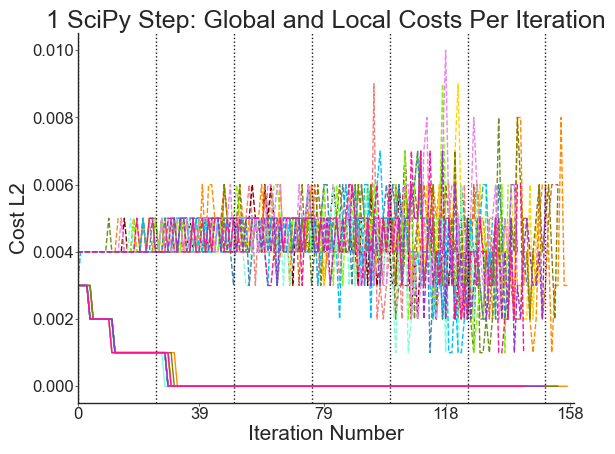

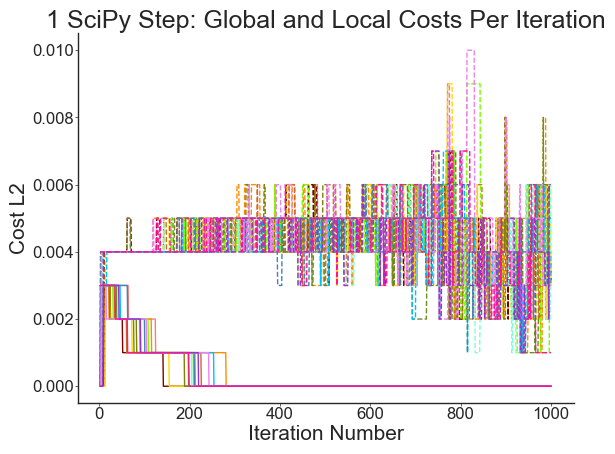

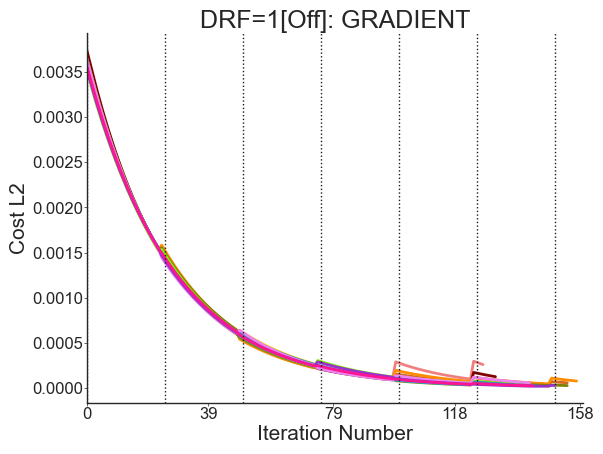

In [16]:
users_c1_1ss = [Client(i, D_0_7, 'EtaScipyMinStep', cond1b1_dict_list[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_c1_1ss = Server(1, D_0_7, 'FedAvg', users_c1_1ss)

big_loop_iters = 1000
for i in range(big_loop_iters):
    global_c1_1ss.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_c1_1ss.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(users_c1_1ss, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(global_c1_1ss, 'global', show_update_change=False, custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(users_c1_1ss, 'local', dim_reduc_factor=1, plot_gradient=True, local_error=False, global_error=False, custom_title='DRF=1[Off]: GRADIENT')

In [17]:
random.seed(a=27)
#cond2b1_AllInitDecs_list[i]
# Replaced the above since then init dec is 2x64 when all should be 2x7

users_c2_1ss = [Client(i, np.random.rand(2,7), 'EtaScipyMinStep', cond2b1_dict_list[i], 'streaming', condition_number=2, delay_scaling=0) for i in range(14)]
global_c2_1ss = Server(-1, np.random.rand(2,7), 'FedAvg', users_c2_1ss)

users_c3_1ss = [Client(i, np.random.rand(2,7), 'EtaScipyMinStep', cond2b1_dict_list[i], 'streaming', condition_number=3, delay_scaling=0) for i in range(14)]
global_c3_1ss = Server(-1, np.random.rand(2,7), 'FedAvg', users_c3_1ss)

users_c4_1ss = [Client(i, np.random.rand(2,7), 'FullScipyMinStep', cond4b1_dict_list[i], 'streaming', condition_number=4, delay_scaling=0) for i in range(14)]
global_c4_1ss = Server(-1, np.random.rand(2,7), 'FedAvg', users_c4_1ss)

users_c5_1ss = [Client(i, np.random.rand(2,7), 'FullScipyMinStep', cond5b1_dict_list[i], 'streaming', condition_number=5, delay_scaling=0) for i in range(14)]
global_c5_1ss = Server(-1, np.random.rand(2,7), 'FedAvg', users_c5_1ss)

users_c6_1ss = [Client(i, np.random.rand(2,7), 'FullScipyMinStep', cond6b1_dict_list[i], 'streaming', condition_number=6, delay_scaling=0) for i in range(14)]
global_c6_1ss = Server(-1, np.random.rand(2,7), 'FedAvg', users_c6_1ss)

users_c7_1ss = [Client(i, np.random.rand(2,7), 'FullScipyMinStep', cond7b1_dict_list[i], 'streaming', condition_number=7, delay_scaling=0) for i in range(14)]
global_c7_1ss = Server(-1, np.random.rand(2,7), 'FedAvg', users_c7_1ss)

users_c8_1ss = [Client(i, np.random.rand(2,7), 'FullScipyMinStep', cond8b1_dict_list[i], 'streaming', condition_number=8, delay_scaling=0) for i in range(14)]
global_c8_1ss = Server(-1, np.random.rand(2,7), 'FedAvg', users_c8_1ss)

for i in range(big_loop_iters):
    global_c2_1ss.execute_FL_loop()
    global_c3_1ss.execute_FL_loop()
    global_c4_1ss.execute_FL_loop()
    global_c5_1ss.execute_FL_loop()
    global_c6_1ss.execute_FL_loop()
    global_c7_1ss.execute_FL_loop()
    global_c8_1ss.execute_FL_loop()

In [18]:
t0 = time.time()

users_lst = [users_c1_1ss, users_c2_1ss, users_c3_1ss, users_c4_1ss, users_c5_1ss, users_c6_1ss, users_c7_1ss, users_c8_1ss]
cond_dfs = [pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec']) for _ in range(8)]
global_cond_dfs = [pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec']) for _ in range(8)]

for key_idx, key in enumerate(keys):
    #df1.loc[len(dec_flattened1)] = [key, update_number, np.ravel(users_c1_1ss[key_idx].dec_log[update_number])]
    for cond_number in range(8):
        update_number = 10
        for current_iter in range(len(users_lst[cond_number][key_idx].dec_log)):
            if update_number==17:
                # Skip the last update
                # We shouldn't reach this with just 500 iters
                print("LAST UPDATE")
                continue
            elif current_iter!=0 and current_iter%users_lst[cond_number][key_idx].local_round_threshold==0:
                update_number+=1
                if update_number==17:
                    continue
            # Local decoder
            cond_dfs[cond_number].loc[cond_dfs[cond_number].shape[0]] = [key, update_number, np.ravel(users_lst[cond_number][key_idx].dec_log[current_iter])]
            # Global decoder
            global_cond_dfs[cond_number].loc[global_cond_dfs[cond_number].shape[0]] = [key, update_number, np.ravel(users_lst[cond_number][key_idx].global_dec_log[current_iter])]


t1 = time.time()
total = t1-t0  
print(total)

60.27867770195007


In [19]:
# Concat all the dfs into a single training input dataframe
dec_flattened_1ss = pd.concat([cond_dfs[0], cond_dfs[1], cond_dfs[2], cond_dfs[3], cond_dfs[4], cond_dfs[5], cond_dfs[6], cond_dfs[7]], ignore_index=True, axis=0)

# Make each ele its own cell
expanded_dec_df_1ss = dec_flattened_1ss.join(dec_flattened_1ss['Flattened Dec'].apply(pd.Series)).drop('Flattened Dec', axis=1)
print(expanded_dec_df_1ss.shape)
expanded_dec_df_1ss.head()

(16112, 16)


,Subject,Update Number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,METACPHS_S106,10,0.945855,0.730307,0.426510,0.046396,0.553901,0.742367,0.283715,0.040858,0.365623,0.257736,0.399879,0.089053,0.040641,0.636716
1,METACPHS_S106,10,0.903083,0.696725,0.408210,0.044488,0.530241,0.710770,0.271782,0.038811,0.350475,0.246775,0.382907,0.085286,0.038875,0.609568
2,METACPHS_S106,10,0.871003,0.671538,0.394485,0.043056,0.512495,0.687073,0.262832,0.037276,0.339114,0.238554,0.370177,0.082461,0.037551,0.589207
3,METACPHS_S106,10,0.838214,0.645737,0.380397,0.041587,0.494280,0.662747,0.253645,0.035707,0.327477,0.230116,0.357111,0.079561,0.036191,0.568305
4,METACPHS_S106,10,0.807076,0.621203,0.366986,0.040188,0.476938,0.639587,0.244898,0.034216,0.316410,0.222083,0.344671,0.076800,0.034897,0.548405


In [20]:
expanded_dec_df_1ss.tail()

,Subject,Update Number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
16107,METACPHS_S119,15,0.092604,0.160354,-0.028464,-0.062829,-0.001080,-0.030215,0.005246,0.126131,-0.133882,-0.049230,0.018142,0.010828,0.003210,0.016284
16108,METACPHS_S119,15,0.092600,0.160331,-0.028463,-0.062821,-0.001076,-0.030208,0.005244,0.126105,-0.133842,-0.049229,0.018143,0.010826,0.003209,0.016284
16109,METACPHS_S119,16,0.012963,0.132596,-0.005120,-0.049375,0.014761,-0.013096,0.001623,-0.045350,-0.104612,-0.024022,0.041745,0.000941,-0.004980,0.013830
16110,METACPHS_S119,16,-0.006910,0.125639,0.000778,-0.045982,0.018751,-0.008797,0.000708,-0.088192,-0.097309,-0.017593,0.047710,-0.001471,-0.006992,0.013193
16111,METACPHS_S119,16,-0.013352,0.109224,0.015784,-0.037183,0.029582,0.002954,-0.001794,-0.102115,-0.080041,-0.001342,0.063163,-0.008156,-0.012584,0.011483


In [21]:
print(f"Number of NANs in DF: {set(expanded_dec_df_1ss.isnull().sum(axis=1))}")
present_updates = expanded_dec_df_1ss['Update Number'].unique()
print(f"Update Numbers Present in DF: {present_updates}")

Number of NANs in DF: {0}
Update Numbers Present in DF: [10 11 12 13 14 15 16]


In [22]:
full_test_df_1ss = make_all_update_models(expanded_dec_df_1ss, n_start_stop=(present_updates[0], present_updates[-1]), stratification=True)
full_test_df_1ss.head()

C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3

,Algorithm,Test Acc,N
0,LogisticRegression(),37.5,10
0,KNeighborsClassifier(),80.833,10
0,GaussianNB(),18.571,10
0,LinearSVC(),39.048,10
0,SGDClassifier(),26.786,10


In [23]:
lr_df_1ss = full_test_df_1ss[full_test_df_1ss['Algorithm']=='LogisticRegression()']
knn_df_1ss = full_test_df_1ss[full_test_df_1ss['Algorithm']=='KNeighborsClassifier()']
svc_df_1ss = full_test_df_1ss[full_test_df_1ss['Algorithm']=='LinearSVC()']
sgd_df_1ss = full_test_df_1ss[full_test_df_1ss['Algorithm']=='SGDClassifier()']
dt_df_1ss = full_test_df_1ss[full_test_df_1ss['Algorithm']=='DecisionTreeClassifier()']
gbt_df_1ss = full_test_df_1ss[full_test_df_1ss['Algorithm']=='GradientBoostingClassifier()']

In [24]:
lr_df_1ss.head()

,Algorithm,Test Acc,N
0,LogisticRegression(),37.5,10
0,LogisticRegression(),32.5,11
0,LogisticRegression(),28.333,12
0,LogisticRegression(),26.667,13
0,LogisticRegression(),23.895,14


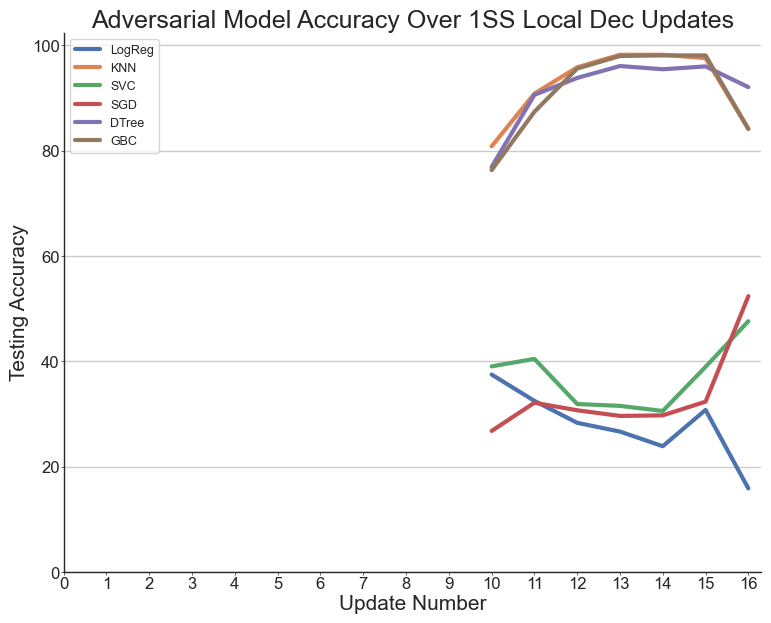

In [25]:
col_num = 1  # Test Acc column
my_x_updates = list(range(present_updates[0], present_updates[-1]+1))

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, lr_df_1ss.iloc[:, col_num], label='LogReg')
plt.plot(my_x_updates, knn_df_1ss.iloc[:, col_num], label='KNN')
plt.plot(my_x_updates, svc_df_1ss.iloc[:, col_num], label='SVC')
plt.plot(my_x_updates, sgd_df_1ss.iloc[:, col_num], label='SGD')
plt.plot(my_x_updates, dt_df_1ss.iloc[:, col_num], label='DTree')
plt.plot(my_x_updates, gbt_df_1ss.iloc[:, col_num], label='GBC')
plt.xticks(np.arange(0, final_update+1, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Adversarial Model Accuracy Over 1SS Local Dec Updates')
plt.legend(loc='best')
plt.show()

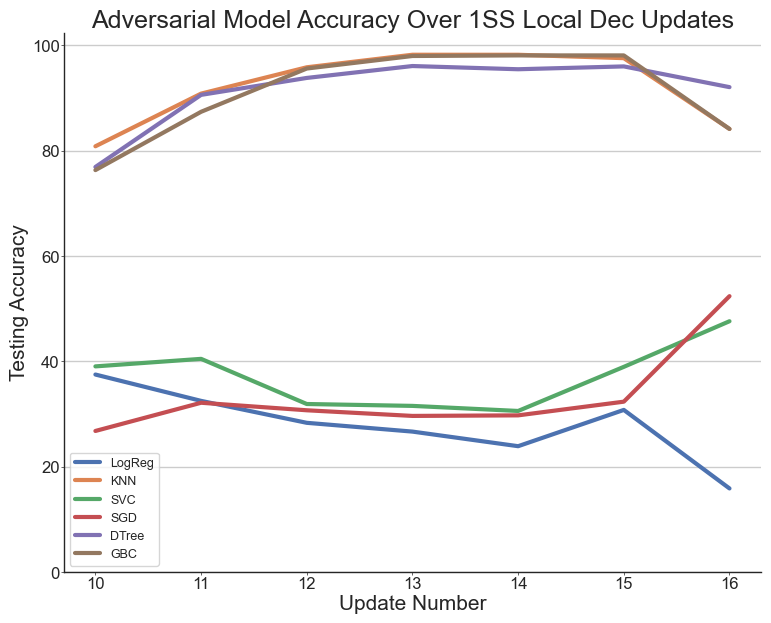

In [26]:
col_num = 1  # Test Acc column
my_x_updates = list(range(present_updates[0], present_updates[-1]+1))

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, lr_df_1ss.iloc[:, col_num], label='LogReg')
plt.plot(my_x_updates, knn_df_1ss.iloc[:, col_num], label='KNN')
plt.plot(my_x_updates, svc_df_1ss.iloc[:, col_num], label='SVC')
plt.plot(my_x_updates, sgd_df_1ss.iloc[:, col_num], label='SGD')
plt.plot(my_x_updates, dt_df_1ss.iloc[:, col_num], label='DTree')
plt.plot(my_x_updates, gbt_df_1ss.iloc[:, col_num], label='GBC')
plt.xticks(np.arange(present_updates[0], final_update+1, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Adversarial Model Accuracy Over 1SS Local Dec Updates')
plt.legend(loc='best')
plt.show()

In [27]:
fl1ss_mean_df = pd.DataFrame()
fl1ss_mean_df = pd.concat([fl1ss_mean_df, knn_df_1ss['Test Acc']], axis=1)
fl1ss_mean_df = pd.concat([fl1ss_mean_df, dt_df_1ss['Test Acc']], axis=1)
fl1ss_mean_df = pd.concat([fl1ss_mean_df, gbt_df_1ss['Test Acc']], axis=1)
fl1ss_good_mean_series = fl1ss_mean_df.mean(axis=1)
print(fl1ss_good_mean_series.shape)
print(fl1ss_good_mean_series)
print()

fl1ss_mean_df = pd.concat([fl1ss_mean_df, lr_df_1ss['Test Acc']], axis=1)
fl1ss_mean_df = pd.concat([fl1ss_mean_df, sgd_df_1ss['Test Acc']], axis=1)
fl1ss_mean_df = pd.concat([fl1ss_mean_df, svc_df_1ss['Test Acc']], axis=1)
fl1ss_all_mean_series = fl1ss_mean_df.mean(axis=1)
print(fl1ss_all_mean_series.shape)
print(fl1ss_all_mean_series)

(7,)
0    78.016000
0    89.603000
0    95.079333
0    97.420333
0    97.252000
0    97.217333
0    86.772333
dtype: float64

(7,)
0    56.230333
0    62.321333
0    62.698333
0    63.353167
0    62.664167
0    65.623333
0    62.698333
dtype: float64


It goes from 80 to nearly 100!  Obvious personalization.  I have a few questions, namely why do some models perform so poorly, why does accuracy drop at the end (just less clients reach those higher update numbers?), and why is the initial accuracy so high if they are init'd to random decs?  Maybe turn off the seed, but I think that would just implicitly be using another seed right...

In [28]:
print(expanded_dec_df_1ss.shape)
samples_per_update = expanded_dec_df_1ss['Update Number'].value_counts()
print(samples_per_update)

(16112, 16)
10    2800
11    2800
12    2800
13    2800
14    2788
15    1915
16     209
Name: Update Number, dtype: int64


<BarContainer object of 7 artists>

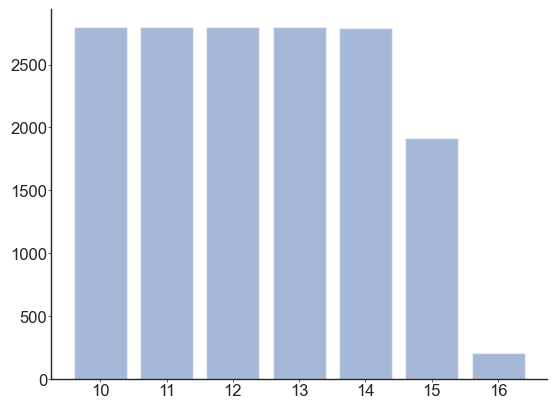

In [29]:
plt.bar(present_updates, samples_per_update, alpha=0.5)#, width, bottom, align)

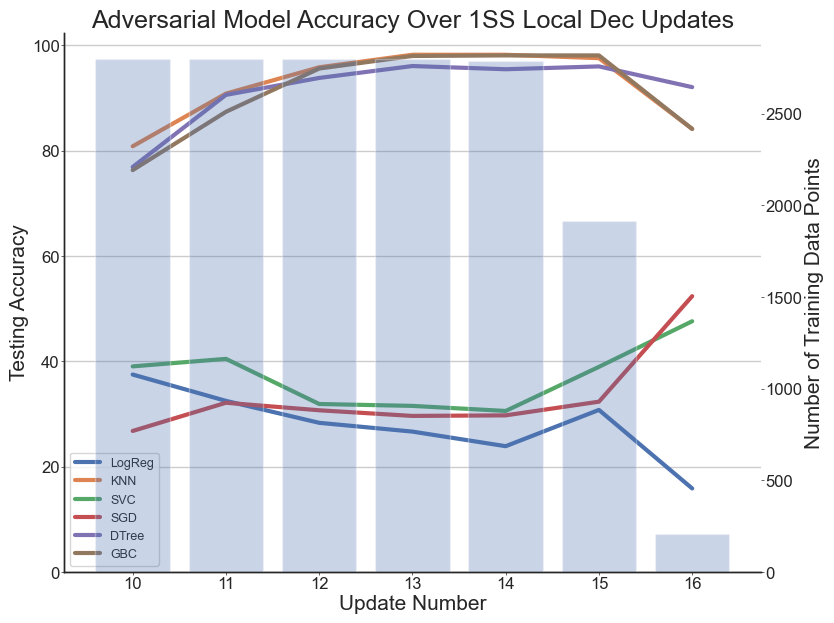

<Figure size 900x700 with 0 Axes>

In [30]:
col_num = 1  # Test Acc column
my_x_updates = list(range(present_updates[0], present_updates[-1]+1))

fig, ax1 = plt.subplots(figsize=(9,7))

ax2 = ax1.twinx()

plt.figure(figsize=(9,7))
ax1.plot(my_x_updates, lr_df_1ss.iloc[:, col_num], label='LogReg')
ax1.plot(my_x_updates, knn_df_1ss.iloc[:, col_num], label='KNN')
ax1.plot(my_x_updates, svc_df_1ss.iloc[:, col_num], label='SVC')
ax1.plot(my_x_updates, sgd_df_1ss.iloc[:, col_num], label='SGD')
ax1.plot(my_x_updates, dt_df_1ss.iloc[:, col_num], label='DTree')
ax1.plot(my_x_updates, gbt_df_1ss.iloc[:, col_num], label='GBC')

ax1.set_xticks(np.arange(present_updates[0], final_update+1, 1.0))
ax1.set_yticks(np.arange(0, 120, 20.0))
ax1.grid(axis='y')
ax1.set_xlabel('Update Number')
ax1.set_ylabel('Testing Accuracy')
ax1.set_title('Adversarial Model Accuracy Over 1SS Local Dec Updates')
#ax1.legend(loc='best')

ax2.bar(present_updates, samples_per_update, alpha=0.3)#, width, bottom, align)
ax2.set_ylabel('Number of Training Data Points')

ax1.legend(loc='best')

plt.show()

In [31]:
# Toy plot showing how to plot 2 sets with 2 y axes on the same plot
# Would have to switch the other code over to ax. instead of plt. ...
#
#x = np.arange(0, 10, 0.1)
#y1 = 0.05 * x**2
#y2 = -1 *y1
#
#fig, ax1 = plt.subplots()
#
#ax2 = ax1.twinx()
#ax1.plot(x, y1, 'g-')
#ax2.plot(x, y2, 'b-')
#
#ax1.set_xlabel('X data')
#ax1.set_ylabel('Y1 data', color='g')
#ax2.set_ylabel('Y2 data', color='b')
#ax2.set_ylim(-10, 0)
#
#plt.show()

That's interesting that 10, 11, 12, 13 all have the same.  This is because we run 25 local iters per client.  Thus 2800 indicates 2800/14=200, 200/25=8, thus we recover the 8 conditions.  E.g. we have 14 clients, each who runs 25 iters, and 8 instances of each client (the 8 conditions).  The lowering in rounds 13, 14, and 15 indicate the random nature where some clients do not get chosen and thus do not make it to the later rounds

# Global Model Privacy Analysis

In [32]:
# Concat all the dfs into a single training input dataframe
global_dec_flattened_1ss = pd.concat([global_cond_dfs[0], global_cond_dfs[1], global_cond_dfs[2], global_cond_dfs[3], global_cond_dfs[4], global_cond_dfs[5], global_cond_dfs[6], global_cond_dfs[7]], ignore_index=True, axis=0)

# Make each ele its own cell
global_expanded_dec_df_1ss = global_dec_flattened_1ss.join(global_dec_flattened_1ss['Flattened Dec'].apply(pd.Series)).drop('Flattened Dec', axis=1)
print(global_expanded_dec_df_1ss.shape)
global_expanded_dec_df_1ss.head()

(16112, 16)


,Subject,Update Number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,METACPHS_S106,10,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,METACPHS_S106,10,1.0,0.774229,0.452421,0.049091,0.588212,0.788003,0.301170,0.042915,0.387609,0.273213,0.424362,0.094462,0.043184,0.675929
2,METACPHS_S106,10,1.0,0.775442,0.453119,0.049460,0.590693,0.792215,0.302739,0.043739,0.388131,0.274972,0.426256,0.095191,0.043190,0.679276
3,METACPHS_S106,10,1.0,0.774736,0.453766,0.049426,0.589286,0.789678,0.301906,0.043159,0.389619,0.273923,0.425619,0.094777,0.043268,0.677575
4,METACPHS_S106,10,1.0,0.803014,0.467515,0.050573,0.607739,0.814411,0.311068,0.043352,0.400560,0.281979,0.438384,0.097684,0.044710,0.698448


In [33]:
print(f"Number of NANs in DF: {set(global_expanded_dec_df_1ss.isnull().sum(axis=1))}")
global_present_updates = global_expanded_dec_df_1ss['Update Number'].unique()
print(f"Update Numbers Present in DF: {global_present_updates}")

Number of NANs in DF: {0}
Update Numbers Present in DF: [10 11 12 13 14 15 16]


In [34]:
global_full_test_df_1ss = make_all_update_models(global_expanded_dec_df_1ss, n_start_stop=(global_present_updates[0], global_present_updates[-1]), stratification=True)
global_full_test_df_1ss.head()

C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the n

C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,Algorithm,Test Acc,N
0,LogisticRegression(),6.786,10
0,KNeighborsClassifier(),6.429,10
0,GaussianNB(),6.19,10
0,LinearSVC(),6.667,10
0,SGDClassifier(),6.548,10


In [35]:
global_lr_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='LogisticRegression()']
global_knn_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='KNeighborsClassifier()']
global_svc_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='LinearSVC()']
global_sgd_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='SGDClassifier()']
global_dt_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='DecisionTreeClassifier()']
global_gbt_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='GradientBoostingClassifier()']

In [36]:
global_lr_df_1ss.head()

,Algorithm,Test Acc,N
0,LogisticRegression(),6.786,10
0,LogisticRegression(),7.857,11
0,LogisticRegression(),8.333,12
0,LogisticRegression(),6.071,13
0,LogisticRegression(),7.288,14


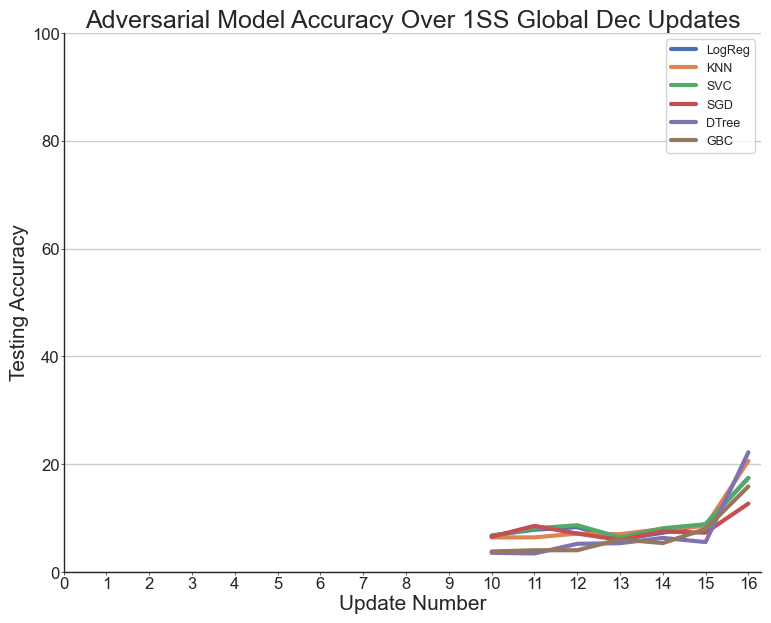

In [37]:
col_num = 1  # Test Acc column
my_global_x_updates = list(range(global_present_updates[0], global_present_updates[-1]+1))

plt.figure(figsize=(9,7))
plt.plot(my_global_x_updates, global_lr_df_1ss.iloc[:, col_num], label='LogReg')
plt.plot(my_global_x_updates, global_knn_df_1ss.iloc[:, col_num], label='KNN')
plt.plot(my_global_x_updates, global_svc_df_1ss.iloc[:, col_num], label='SVC')
plt.plot(my_global_x_updates, global_sgd_df_1ss.iloc[:, col_num], label='SGD')
plt.plot(my_global_x_updates, global_dt_df_1ss.iloc[:, col_num], label='DTree')
plt.plot(my_global_x_updates, global_gbt_df_1ss.iloc[:, col_num], label='GBC')
plt.xticks(np.arange(0, final_update+1, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Adversarial Model Accuracy Over 1SS Global Dec Updates')
plt.legend(loc='best')
plt.show()

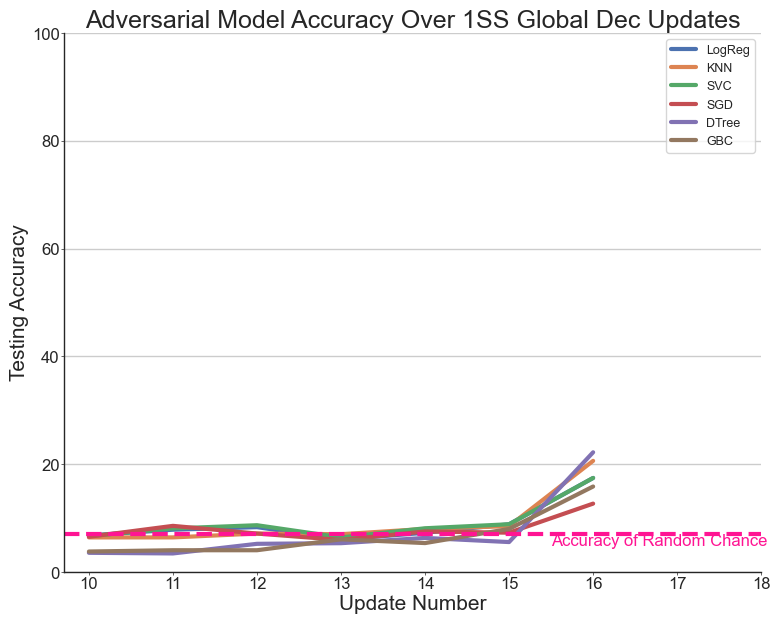

In [38]:
col_num = 1  # Test Acc column

plt.figure(figsize=(9,7))
plt.plot(my_global_x_updates, global_lr_df_1ss.iloc[:, col_num], label='LogReg')
plt.plot(my_global_x_updates, global_knn_df_1ss.iloc[:, col_num], label='KNN')
plt.plot(my_global_x_updates, global_svc_df_1ss.iloc[:, col_num], label='SVC')
plt.plot(my_global_x_updates, global_sgd_df_1ss.iloc[:, col_num], label='SGD')
plt.plot(my_global_x_updates, global_dt_df_1ss.iloc[:, col_num], label='DTree')
plt.plot(my_global_x_updates, global_gbt_df_1ss.iloc[:, col_num], label='GBC')

plt.axhline(7.14, linestyle='dashed', color='deeppink')
plt.text(15.5,5,'Accuracy of Random Chance', color='deeppink')

plt.xticks(np.arange(global_present_updates[0], 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Adversarial Model Accuracy Over 1SS Global Dec Updates')
plt.legend(loc='best')
plt.show()

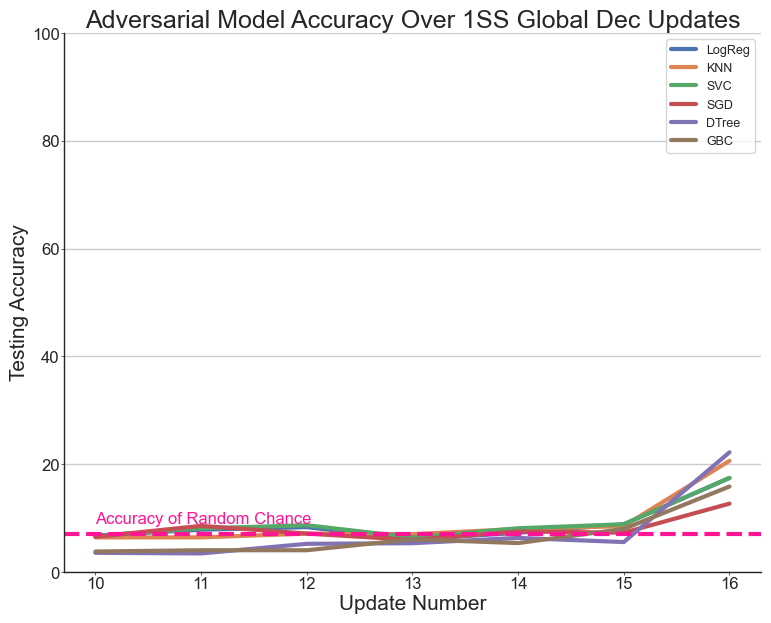

In [39]:
col_num = 1  # Test Acc column

plt.figure(figsize=(9,7))
plt.plot(my_global_x_updates, global_lr_df_1ss.iloc[:, col_num], label='LogReg')
plt.plot(my_global_x_updates, global_knn_df_1ss.iloc[:, col_num], label='KNN')
plt.plot(my_global_x_updates, global_svc_df_1ss.iloc[:, col_num], label='SVC')
plt.plot(my_global_x_updates, global_sgd_df_1ss.iloc[:, col_num], label='SGD')
plt.plot(my_global_x_updates, global_dt_df_1ss.iloc[:, col_num], label='DTree')
plt.plot(my_global_x_updates, global_gbt_df_1ss.iloc[:, col_num], label='GBC')

plt.axhline(7.14, linestyle='dashed', color='deeppink')
plt.text(10,9,'Accuracy of Random Chance', color='deeppink')

plt.xticks(np.arange(global_present_updates[0], final_update+1, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Adversarial Model Accuracy Over 1SS Global Dec Updates')
plt.legend(loc='best')
plt.show()

In [40]:
global1ss_mean_df = pd.DataFrame()
global1ss_mean_df = pd.concat([global1ss_mean_df, global_lr_df_1ss['Test Acc']], axis=1)
global1ss_mean_df = pd.concat([global1ss_mean_df, global_knn_df_1ss['Test Acc']], axis=1)
global1ss_mean_df = pd.concat([global1ss_mean_df, global_svc_df_1ss['Test Acc']], axis=1)
global1ss_mean_df = pd.concat([global1ss_mean_df, global_sgd_df_1ss['Test Acc']], axis=1)
global1ss_mean_df = pd.concat([global1ss_mean_df, global_gbt_df_1ss['Test Acc']], axis=1)
global1ss_mean_df = pd.concat([global1ss_mean_df, global_dt_df_1ss['Test Acc']], axis=1)

global1ss_mean_series = global1ss_mean_df.mean(axis=1)
print(global1ss_mean_series.shape)
print(global1ss_mean_series)

(7,)
0     5.635167
0     6.408667
0     6.765833
0     6.150667
0     7.108667
0     7.855167
0    17.724667
dtype: float64


- nofl_mean_series
- nofl_mean_series_no_dt
- fl1ss_good_mean_series
- fl1ss_all_mean_series
- global1ss_mean_series

In [41]:
# Legendary Github issue page dub
#https://github.com/matplotlib/matplotlib/issues/3706

#ax = plt.subplot(111)
#ax2.twinx()
## ... some plotting
#leg = ax.legend()
#leg.remove()
#ax2.add_artist(leg)

## Paper Version

## Presentation Version

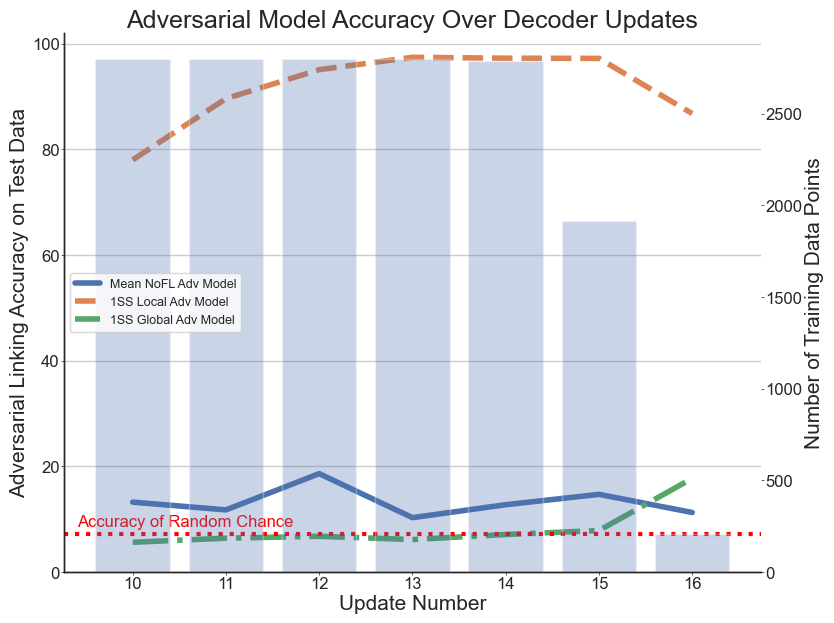

<Figure size 900x700 with 0 Axes>

In [42]:
fl_x_updates = list(range(present_updates[0], present_updates[-1]+1))

fig, ax1 = plt.subplots(figsize=(9,7))

ax2 = ax1.twinx()

plt.figure(figsize=(9,7))
ax1.plot(fl_x_updates, nofl_mean_series[10:], linewidth=4, label='Mean NoFL Adv Model')
ax1.plot(fl_x_updates, fl1ss_good_mean_series, linewidth=4, linestyle='dashed', label='1SS Local Adv Model')
ax1.plot(fl_x_updates, global1ss_mean_series, linewidth=4, linestyle='dashdot', label='1SS Global Adv Model')

ax1.set_xticks(np.arange(present_updates[0], final_update+1, 1.0))
ax1.set_yticks(np.arange(0, 120, 20.0))
ax1.grid(axis='y')
ax1.set_xlabel('Update Number')
ax1.set_ylabel('Adversarial Linking Accuracy on Test Data')
ax1.set_title('Adversarial Model Accuracy Over Decoder Updates')

#plt.axhline(7.14, linestyle='dashed', color='deeppink')
#plt.text(10,9,'Accuracy of Random Chance', color='deeppink')
ax1.axhline(7.14, linestyle='dotted', color='red')
ax1.text(9.4,8.7,'Accuracy of Random Chance', color='red')

ax2.bar(present_updates, samples_per_update, alpha=0.3)#, width, bottom, align)
ax2.set_ylabel('Number of Training Data Points')

# use parameter bbox_to_anchor to reposition
# the legend box outside the plot area
ax1.legend(loc='center left', bbox_to_anchor=(0.35, -0.15))
#ax1.legend(loc='best')

#ax2.twinx()
leg = ax1.legend(loc='center left')
leg.remove()
ax2.add_artist(leg)

#ax1.spines[['right', 'top']].set_visible(False)
#ax2.spines[['right', 'top']].set_visible(False)
ax1.spines[['top']].set_visible(False)
ax2.spines[['top']].set_visible(False)

In [56]:
dec_flattened_sb1 = pd.read_csv("Data\pers_decs_sb1.csv")
dec_flattened_sb1.drop('Unnamed: 0', axis=1, inplace=True)
dec_flattened_sb1.head()

,Subject,Update Number,Flattened Dec
0,METACPHS_S106,10,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1,METACPHS_S106,10,[5.42823589e-01 2.33230353e-01 3.18512685e-01 ...
2,METACPHS_S106,10,[ 5.39089760e-01 2.35161475e-01 3.23998288e-...
3,METACPHS_S106,10,[0.52377607 0.23478194 0.3171932 0.00425936 0...
4,METACPHS_S106,10,[0.52610725 0.23335771 0.32281358 0.00210236 0...


These should not be strings.... rework them smh

In [57]:
# Make each ele its own cell
expanded_dec_df_sb1 = dec_flattened_sb1.join(dec_flattened_sb1['Flattened Dec'].apply(pd.Series)).drop('Flattened Dec', axis=1)
print(expanded_dec_df_sb1.shape)
expanded_dec_df_sb1.head()

(1014, 3)


,Subject,Update Number,0
0,METACPHS_S106,10,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1,METACPHS_S106,10,[5.42823589e-01 2.33230353e-01 3.18512685e-01 ...
2,METACPHS_S106,10,[ 5.39089760e-01 2.35161475e-01 3.23998288e-...
3,METACPHS_S106,10,[0.52377607 0.23478194 0.3171932 0.00425936 0...
4,METACPHS_S106,10,[0.52610725 0.23335771 0.32281358 0.00210236 0...


In [ ]:
full_test_df_1ss = make_all_update_models(expanded_dec_df_1ss, n_start_stop=(present_updates[0], present_updates[-1]), stratification=True)
full_test_df_1ss.head()

In [ ]:
global_lr_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='LogisticRegression()']
global_knn_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='KNeighborsClassifier()']
global_svc_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='LinearSVC()']
global_sgd_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='SGDClassifier()']
global_dt_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='DecisionTreeClassifier()']
global_gbt_df_1ss = global_full_test_df_1ss[global_full_test_df_1ss['Algorithm']=='GradientBoostingClassifier()']